# Exploratory Data Analysis (EDA) – Supply Chain Intelligence
## Objective

This notebook focuses exclusively on Exploratory Data Analysis (EDA) for the Supply Chain Intelligence project. The goal is to understand transactional patterns, operational workload, temporal behavior, and inflation-adjusted economic signals before any modeling or clustering is applied.

This separation ensures:

- Clear analytical storytelling

- Reproducibility

- Proper ML lifecycle discipline (EDA → Feature Engineering → Modeling)

# 1. Environment Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Project Paths & Data Loading

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PATH = os.path.join(
PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)


df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

In [5]:
display(df.head())
df.info()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Period
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Year 2009-2010
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Year 2009-2010
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Year 2009-2010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Year 2009-2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014932 entries, 0 to 1014931
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1014932 non-null  int64         
 1   StockCode    1014932 non-null  object        
 2   Description  1014932 non-null  object        
 3   Quantity     1014932 non-null  int64         
 4   InvoiceDate  1014932 non-null  datetime64[ns]
 5   Price        1014932 non-null  float64       
 6   Customer ID  786083 non-null   float64       
 7   Country      1014932 non-null  object        
 8   Period       1014932 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 69.7+ MB


# 3. Feature Validation & Revenue Construction

In [7]:
if "TotalSum" not in df.columns:
    df["TotalSum"] = df["Quantity"] * df["Price"]


df["Year"] = df["InvoiceDate"].dt.year

### Rationale:

- Ensures monetary consistency

- Allows temporal segmentation (2010 vs 2011)

# 4. Inflation Adjustment (Constant Prices)

To enable intertemporal comparability, 2011 prices are deflated to 2010 GBP. 

In [8]:
INFLATION_2011 = 0.039 # UK CPI 2011 ≈ 3.9%


mask_2011 = df["Year"] == 2011


df.loc[mask_2011, ["TotalSum", "Price"]] /= (1 + INFLATION_2011)

# 5. Temporal Decomposition

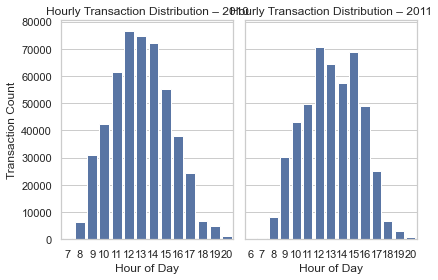

In [ ]:
df["DayName"] = df["InvoiceDate"].dt.day_name()
df["Hour"] = df["InvoiceDate"].dt.hour

# Transaction Volume by Day of Week
DAYS_ORDER = [
"Monday", "Tuesday", "Wednesday",
"Thursday", "Friday", "Saturday", "Sunday"
]

day_share = (
df.groupby(["Year", "DayName"])
.size()
.groupby(level=0)
.apply(lambda x: 100 * x / x.sum())
.unstack()
.reindex(columns=DAYS_ORDER)
)

day_share

# Hourly Operational Peaks

fig, axes = plt.subplots(1, 2, sharey=True)

for ax, year in zip(axes, [2010, 2011]):
    sns.countplot(
    data=df[df["Year"] == year],
    x="Hour",
    ax=ax
    )
    ax.set_title(f"Hourly Transaction Distribution – {year}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Transaction Count")

plt.tight_layout()
plt.show()

### Insight:

- Reveals demand peaks

- Informs shift planning and system load

# Revenue Distribution Analysis

In [13]:
revenue_by_sku = (
df.groupby("Description", as_index=False)["TotalSum"]
.sum()
.sort_values("TotalSum", ascending=False)
)


revenue_by_sku.head(10)

,Description,TotalSum
3753,REGENCY CAKESTAND 3 TIER,250956.104100
5065,WHITE HANGING HEART T-LIGHT HOLDER,187323.986208
3146,PARTY BUNTING,130086.218980
2389,JUMBO BAG RED RETROSPOT,102480.113609
3114,PAPER CHAIN KIT 50'S CHRISTMAS,81170.082368
295,ASSORTED COLOUR BIRD ORNAMENT,76024.723436
3531,POSTAGE,73415.727353
997,CHILLI LIGHTS,67685.683282
1004,CHOCOLATE HOT WATER BOTTLE,59192.483859
2271,HOT WATER BOTTLE TEA AND SYMPATHY,58243.865313


# Key EDA Takeaways

- Transaction volume is temporally concentrated (weekday & hourly peaks)

- Nominal growth disappears after inflation adjustment

- Revenue follows a Pareto-like distribution

- Data is suitable for:

    - RFM segmentation

    - ABC inventory classification

    - Customer lifetime analysis

# Next Step

➡ Proceed to RFM Feature Engineering & Clustering in a dedicated notebook (02_rfm_clustering.ipynb).